In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision.models as models
from torch.autograd import Variable
import numpy as np
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm 
from sklearn.model_selection import train_test_split
import torchvision
from torchvision import transforms
import math
from PIL import Image
from torchsummary import summary

%matplotlib inline

h, w = 64, 64

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.backends.cudnn.benchmark = True

print(device)

cuda:0


In [2]:
def resize (img):
    im = Image.fromarray(img)
    im.thumbnail((h, w), Image.ANTIALIAS)
    im = np.array(im).astype('float32')
    return np.pad(im, (((h - im.shape[0]) // 2, (h - im.shape[0] + 1) // 2), ((w - im.shape[1]) // 2, (w - im.shape[1] + 1) // 2)), 'constant', constant_values=255)

In [3]:
data1 = np.load('train-1.npy')
data2 = np.load('train-2.npy')
data3 = np.load('train-3.npy')
data4 = np.load('train-4.npy')
train = np.concatenate((data1, data2, data3, data4), axis=0)

train[:, 0] = [resize(img) for img in tqdm(train[:, 0])]
train[:, 0] /= 255

100%|████████████████████████████████████████████████████████████████████████| 332987/332987 [02:44<00:00, 2025.38it/s]


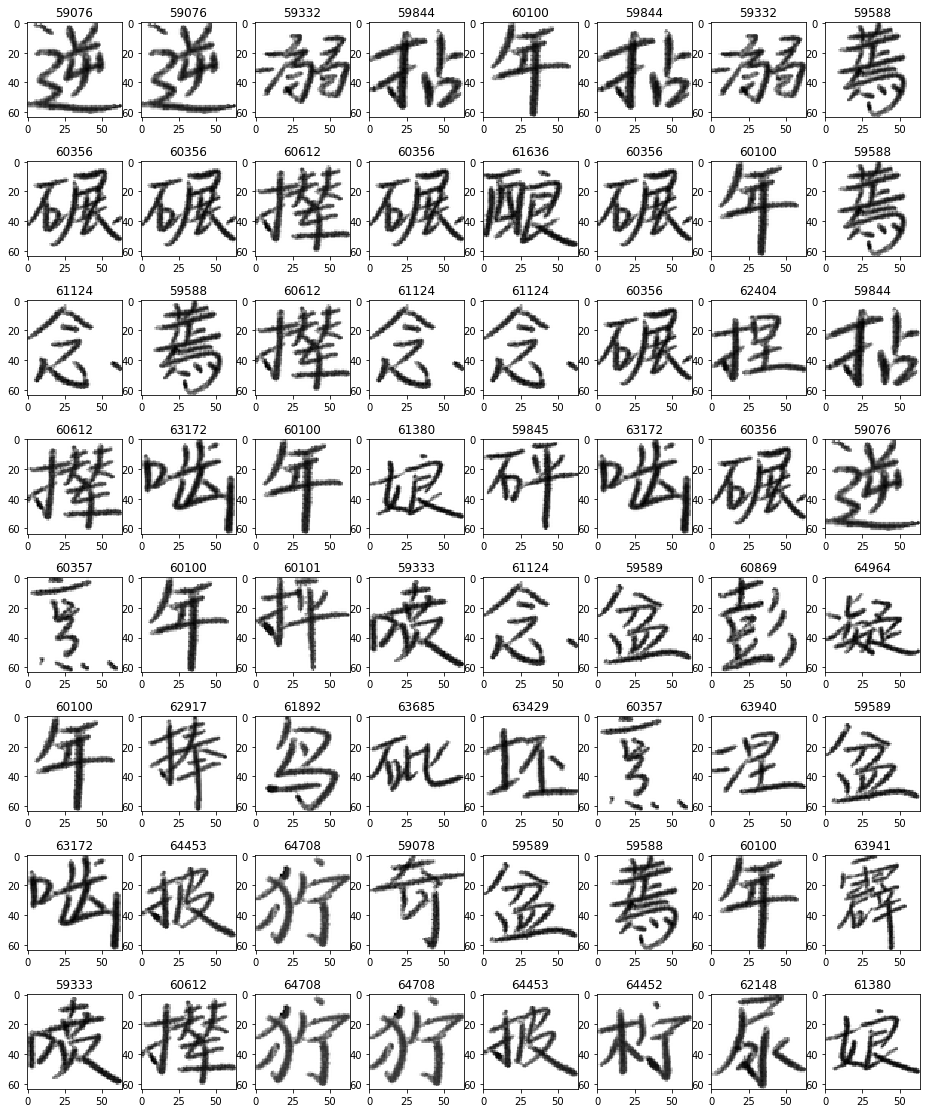

In [4]:
plt.figure(figsize=(16, 20))
for n, (image, tag) in enumerate(train, 1):
    if n > 64:
        break
    plt.subplot(8, 8, n)
    plt.title(tag)
    plt.imshow(image, cmap='gray')

In [5]:
print(train[10, 0].shape)

(64, 64)


In [6]:
dct = dict(zip(range(1000), np.unique(train[:, 1])))
dct = {v:k for k,v in dct.items()}

train[:, 1] = [dct[code] for code in train[:, 1]]

train, test = train_test_split(train, test_size=0.2, random_state=113)

In [7]:
train_x_np, train_y_np = train[:, 0], np.array(train[:, 1], dtype='int32')
test_x_np, test_y_np = test[:, 0], np.array(test[:, 1], dtype='int32')

train_x_np = np.array([i[:, :, np.newaxis] for i in tqdm(train_x_np)])
test_x_np = np.array([i[:, :, np.newaxis] for i in tqdm(test_x_np)])

del train
del test

100%|█████████████████████████████████████████████████████████████████████| 332987/332987 [00:00<00:00, 1213829.06it/s]


In [8]:
import gc
gc.collect()

112591

In [9]:
class Hieroglyph_data(Dataset):
    def __init__(self, tX, tY = None,
                 transform = transforms.Compose(
                     [transforms.ToPILImage(), 
                      transforms.ToTensor(), 
                      transforms.Normalize(mean=(0.5,), std=(0.5,))]), train=True):
        
        if train == True:
            self.X = tX
            self.y = torch.Tensor(tY).type(torch.LongTensor)
            self.transform = transform
            self.train = True
            
        else:
            self.X = tX
            self.y = None
            self.transform = transform
            self.train = False
            
    def __len__(self):
        return self.X.shape[0]

    def __getitem__(self, idx):
        if self.train == True:
            return self.transform(self.X[idx]), self.y[idx]
        else:
            return self.transform(self.X[idx])

In [10]:
train_dataset = Hieroglyph_data(train_x_np, train_y_np, transform = transforms.Compose(
                                [transforms.ToPILImage(), 
                                 transforms.RandomAffine(
                                 degrees=(-10, 10), 
                                 translate=(.1, .1), 
                                 scale=(.9, 1.1),
                                 shear=(-10, 10)),
                                 transforms.ToTensor(), 
                                 transforms.Normalize(mean=(0.5,), std=(0.5,))]))

test_dataset = Hieroglyph_data(test_x_np, test_y_np)

In [11]:
num_classes = 1000
batch_size = 64
num_epochs = 10

train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [12]:
class Block(nn.Module):
    '''expand + depthwise + pointwise'''
    def __init__(self, in_planes, out_planes, expansion, stride):
        super(Block, self).__init__()
        self.stride = stride

        planes = expansion * in_planes
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=3, stride=stride, padding=1, groups=planes, bias=False)
        self.bn2 = nn.BatchNorm2d(planes)
        self.conv3 = nn.Conv2d(planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False)
        self.bn3 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        if stride == 1 and in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=1, padding=0, bias=False),
                nn.BatchNorm2d(out_planes),
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = F.relu(self.bn2(self.conv2(out)))
        out = self.bn3(self.conv3(out))
        out = out + self.shortcut(x) if self.stride==1 else out
        return out


class MobileNetV2(nn.Module):
    # (expansion, out_planes, num_blocks, stride)
    cfg = [(1,  16, 1, 1),
           (6,  24, 2, 1),  
           (6,  32, 3, 2),
           (6,  64, 4, 2),
           (6,  96, 3, 1),
           (6, 160, 3, 2),
           (6, 320, 1, 1)]

    def __init__(self, num_classes=1000):
        super(MobileNetV2, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=5, stride=1, padding=2, bias=False)
        self.bn1 = nn.BatchNorm2d(32)
        self.layers = self._make_layers(in_planes=32)
        self.conv2 = nn.Conv2d(320, 1280, kernel_size=3, stride=1, padding=0, bias=False)
        self.bn2 = nn.BatchNorm2d(1280)
        self.linear = nn.Linear(1280, num_classes)

    def _make_layers(self, in_planes):
        layers = []
        for expansion, out_planes, num_blocks, stride in self.cfg:
            strides = [stride] + [1]*(num_blocks-1)
            for stride in strides:
                layers.append(Block(in_planes, out_planes, expansion, stride))
                in_planes = out_planes
        return nn.Sequential(*layers)

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.layers(out)
        out = F.relu(self.bn2(self.conv2(out)))
        out = F.avg_pool2d(out, 4)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

model = MobileNetV2()

model = model.to(device)

summary(model, (1, 64, 64))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 32, 64, 64]             800
       BatchNorm2d-2           [-1, 32, 64, 64]              64
            Conv2d-3           [-1, 32, 64, 64]           1,024
       BatchNorm2d-4           [-1, 32, 64, 64]              64
            Conv2d-5           [-1, 32, 64, 64]             288
       BatchNorm2d-6           [-1, 32, 64, 64]              64
            Conv2d-7           [-1, 16, 64, 64]             512
       BatchNorm2d-8           [-1, 16, 64, 64]              32
            Conv2d-9           [-1, 16, 64, 64]             512
      BatchNorm2d-10           [-1, 16, 64, 64]              32
            Block-11           [-1, 16, 64, 64]               0
           Conv2d-12           [-1, 96, 64, 64]           1,536
      BatchNorm2d-13           [-1, 96, 64, 64]             192
           Conv2d-14           [-1, 96,

          Conv2d-125            [-1, 320, 8, 8]         307,200
     BatchNorm2d-126            [-1, 320, 8, 8]             640
          Conv2d-127            [-1, 320, 8, 8]          51,200
     BatchNorm2d-128            [-1, 320, 8, 8]             640
           Block-129            [-1, 320, 8, 8]               0
          Conv2d-130           [-1, 1280, 6, 6]       3,686,400
     BatchNorm2d-131           [-1, 1280, 6, 6]           2,560
          Linear-132                 [-1, 1000]       1,281,000
Total params: 6,841,848
Trainable params: 6,841,848
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forward/backward pass size (MB): 108.95
Params size (MB): 26.10
Estimated Total Size (MB): 135.06
----------------------------------------------------------------


In [13]:
error = nn.CrossEntropyLoss()
#error = error.to(device)

learning_rate = 0.002

optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=2, gamma=0.5)

In [14]:
print('wtf')

def train(epoch):
    model.train()

    for i, (images, labels) in enumerate(train_loader):
        images, labels = images.view(-1, 1, h, w).to(device), labels.to(device)
        
        optimizer.zero_grad()
        
        outputs = model(images)
        
        loss = error(outputs, labels)
        
        loss.backward()
            
        optimizer.step()
        
        if (i + 1)% 50 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, (i+ 1) * len(images), len(train_loader.dataset),
                100. * (i + 1) / len(train_loader), loss.item()))
            
def evaluate(data_loader):
    model.eval()
    loss = 0
    correct = 0
    
    with torch.no_grad():
        for i, (images, labels) in enumerate(data_loader):
            images, labels = images.view(-1, 1, h, w).to(device), labels.to(device)

            outputs = model(images)

            loss += F.cross_entropy(outputs, labels, size_average=False).item()

            pred = outputs.data.max(1, keepdim=True)[1]
            correct += pred.eq(labels.data.view_as(pred)).cpu().sum()
        
    loss /= len(data_loader.dataset)
        
    print('\nAverage loss: {:.4f}, Accuracy: {}/{} ({:.3f}%)\n'.format(
        loss, correct, len(data_loader.dataset),
        100. * correct / len(data_loader.dataset)))

wtf


In [15]:
for epoch in range(num_epochs):
    lr_scheduler.step()
    train(epoch)
    evaluate(test_loader)

Train Epoch: 0 [3200/332987 (1%)]	Loss: 6.901644
Train Epoch: 0 [6400/332987 (2%)]	Loss: 6.895942
Train Epoch: 0 [9600/332987 (3%)]	Loss: 6.911717
Train Epoch: 0 [12800/332987 (4%)]	Loss: 6.909713
Train Epoch: 0 [16000/332987 (5%)]	Loss: 6.904969
Train Epoch: 0 [19200/332987 (6%)]	Loss: 6.908296
Train Epoch: 0 [22400/332987 (7%)]	Loss: 6.918499
Train Epoch: 0 [25600/332987 (8%)]	Loss: 6.914899
Train Epoch: 0 [28800/332987 (9%)]	Loss: 6.918952
Train Epoch: 0 [32000/332987 (10%)]	Loss: 6.916974
Train Epoch: 0 [35200/332987 (11%)]	Loss: 6.913034
Train Epoch: 0 [38400/332987 (12%)]	Loss: 6.916315
Train Epoch: 0 [41600/332987 (12%)]	Loss: 6.812696
Train Epoch: 0 [44800/332987 (13%)]	Loss: 6.716768
Train Epoch: 0 [48000/332987 (14%)]	Loss: 6.592751
Train Epoch: 0 [51200/332987 (15%)]	Loss: 6.516992
Train Epoch: 0 [54400/332987 (16%)]	Loss: 6.256513
Train Epoch: 0 [57600/332987 (17%)]	Loss: 6.410948
Train Epoch: 0 [60800/332987 (18%)]	Loss: 6.280028
Train Epoch: 0 [64000/332987 (19%)]	Loss: 6

Train Epoch: 1 [179200/332987 (54%)]	Loss: 0.494243
Train Epoch: 1 [182400/332987 (55%)]	Loss: 0.209761
Train Epoch: 1 [185600/332987 (56%)]	Loss: 0.228667
Train Epoch: 1 [188800/332987 (57%)]	Loss: 0.286969
Train Epoch: 1 [192000/332987 (58%)]	Loss: 0.199626
Train Epoch: 1 [195200/332987 (59%)]	Loss: 0.251732
Train Epoch: 1 [198400/332987 (60%)]	Loss: 0.089168
Train Epoch: 1 [201600/332987 (61%)]	Loss: 0.152466
Train Epoch: 1 [204800/332987 (62%)]	Loss: 0.266143
Train Epoch: 1 [208000/332987 (62%)]	Loss: 0.280080
Train Epoch: 1 [211200/332987 (63%)]	Loss: 0.048086
Train Epoch: 1 [214400/332987 (64%)]	Loss: 0.356686
Train Epoch: 1 [217600/332987 (65%)]	Loss: 0.166762
Train Epoch: 1 [220800/332987 (66%)]	Loss: 0.366281
Train Epoch: 1 [224000/332987 (67%)]	Loss: 0.190074
Train Epoch: 1 [227200/332987 (68%)]	Loss: 0.290919
Train Epoch: 1 [230400/332987 (69%)]	Loss: 0.186078
Train Epoch: 1 [233600/332987 (70%)]	Loss: 0.163388
Train Epoch: 1 [236800/332987 (71%)]	Loss: 0.257789
Train Epoch:

Train Epoch: 3 [19200/332987 (6%)]	Loss: 0.079399
Train Epoch: 3 [22400/332987 (7%)]	Loss: 0.091142
Train Epoch: 3 [25600/332987 (8%)]	Loss: 0.043663
Train Epoch: 3 [28800/332987 (9%)]	Loss: 0.098938
Train Epoch: 3 [32000/332987 (10%)]	Loss: 0.068845
Train Epoch: 3 [35200/332987 (11%)]	Loss: 0.056184
Train Epoch: 3 [38400/332987 (12%)]	Loss: 0.131279
Train Epoch: 3 [41600/332987 (12%)]	Loss: 0.071511
Train Epoch: 3 [44800/332987 (13%)]	Loss: 0.103312
Train Epoch: 3 [48000/332987 (14%)]	Loss: 0.221736
Train Epoch: 3 [51200/332987 (15%)]	Loss: 0.034199
Train Epoch: 3 [54400/332987 (16%)]	Loss: 0.070496
Train Epoch: 3 [57600/332987 (17%)]	Loss: 0.102975
Train Epoch: 3 [60800/332987 (18%)]	Loss: 0.095836
Train Epoch: 3 [64000/332987 (19%)]	Loss: 0.016219
Train Epoch: 3 [67200/332987 (20%)]	Loss: 0.037560
Train Epoch: 3 [70400/332987 (21%)]	Loss: 0.068496
Train Epoch: 3 [73600/332987 (22%)]	Loss: 0.031244
Train Epoch: 3 [76800/332987 (23%)]	Loss: 0.062343
Train Epoch: 3 [80000/332987 (24%)]

Train Epoch: 4 [192000/332987 (58%)]	Loss: 0.056774
Train Epoch: 4 [195200/332987 (59%)]	Loss: 0.017038
Train Epoch: 4 [198400/332987 (60%)]	Loss: 0.002451
Train Epoch: 4 [201600/332987 (61%)]	Loss: 0.083360
Train Epoch: 4 [204800/332987 (62%)]	Loss: 0.010011
Train Epoch: 4 [208000/332987 (62%)]	Loss: 0.004947
Train Epoch: 4 [211200/332987 (63%)]	Loss: 0.005304
Train Epoch: 4 [214400/332987 (64%)]	Loss: 0.062705
Train Epoch: 4 [217600/332987 (65%)]	Loss: 0.005611
Train Epoch: 4 [220800/332987 (66%)]	Loss: 0.034909
Train Epoch: 4 [224000/332987 (67%)]	Loss: 0.053523
Train Epoch: 4 [227200/332987 (68%)]	Loss: 0.016961
Train Epoch: 4 [230400/332987 (69%)]	Loss: 0.018700
Train Epoch: 4 [233600/332987 (70%)]	Loss: 0.045349
Train Epoch: 4 [236800/332987 (71%)]	Loss: 0.100976
Train Epoch: 4 [240000/332987 (72%)]	Loss: 0.012944
Train Epoch: 4 [243200/332987 (73%)]	Loss: 0.036251
Train Epoch: 4 [246400/332987 (74%)]	Loss: 0.085909
Train Epoch: 4 [249600/332987 (75%)]	Loss: 0.053433
Train Epoch:

Train Epoch: 6 [32000/332987 (10%)]	Loss: 0.034669
Train Epoch: 6 [35200/332987 (11%)]	Loss: 0.008761
Train Epoch: 6 [38400/332987 (12%)]	Loss: 0.043870
Train Epoch: 6 [41600/332987 (12%)]	Loss: 0.016923
Train Epoch: 6 [44800/332987 (13%)]	Loss: 0.076186
Train Epoch: 6 [48000/332987 (14%)]	Loss: 0.003788
Train Epoch: 6 [51200/332987 (15%)]	Loss: 0.027155
Train Epoch: 6 [54400/332987 (16%)]	Loss: 0.012319
Train Epoch: 6 [57600/332987 (17%)]	Loss: 0.025010
Train Epoch: 6 [60800/332987 (18%)]	Loss: 0.102249
Train Epoch: 6 [64000/332987 (19%)]	Loss: 0.023954
Train Epoch: 6 [67200/332987 (20%)]	Loss: 0.224863
Train Epoch: 6 [70400/332987 (21%)]	Loss: 0.029205
Train Epoch: 6 [73600/332987 (22%)]	Loss: 0.007693
Train Epoch: 6 [76800/332987 (23%)]	Loss: 0.012008
Train Epoch: 6 [80000/332987 (24%)]	Loss: 0.006067
Train Epoch: 6 [83200/332987 (25%)]	Loss: 0.004264
Train Epoch: 6 [86400/332987 (26%)]	Loss: 0.004268
Train Epoch: 6 [89600/332987 (27%)]	Loss: 0.038307
Train Epoch: 6 [92800/332987 (2

Train Epoch: 7 [204800/332987 (62%)]	Loss: 0.051030
Train Epoch: 7 [208000/332987 (62%)]	Loss: 0.078079
Train Epoch: 7 [211200/332987 (63%)]	Loss: 0.005645
Train Epoch: 7 [214400/332987 (64%)]	Loss: 0.016412
Train Epoch: 7 [217600/332987 (65%)]	Loss: 0.019035
Train Epoch: 7 [220800/332987 (66%)]	Loss: 0.001873
Train Epoch: 7 [224000/332987 (67%)]	Loss: 0.005441
Train Epoch: 7 [227200/332987 (68%)]	Loss: 0.018864
Train Epoch: 7 [230400/332987 (69%)]	Loss: 0.009226
Train Epoch: 7 [233600/332987 (70%)]	Loss: 0.015438
Train Epoch: 7 [236800/332987 (71%)]	Loss: 0.029634
Train Epoch: 7 [240000/332987 (72%)]	Loss: 0.003807
Train Epoch: 7 [243200/332987 (73%)]	Loss: 0.008663
Train Epoch: 7 [246400/332987 (74%)]	Loss: 0.001919
Train Epoch: 7 [249600/332987 (75%)]	Loss: 0.002948
Train Epoch: 7 [252800/332987 (76%)]	Loss: 0.036160
Train Epoch: 7 [256000/332987 (77%)]	Loss: 0.004077
Train Epoch: 7 [259200/332987 (78%)]	Loss: 0.041258
Train Epoch: 7 [262400/332987 (79%)]	Loss: 0.052558
Train Epoch:

Train Epoch: 9 [44800/332987 (13%)]	Loss: 0.011435
Train Epoch: 9 [48000/332987 (14%)]	Loss: 0.019949
Train Epoch: 9 [51200/332987 (15%)]	Loss: 0.004842
Train Epoch: 9 [54400/332987 (16%)]	Loss: 0.005866
Train Epoch: 9 [57600/332987 (17%)]	Loss: 0.005322
Train Epoch: 9 [60800/332987 (18%)]	Loss: 0.009889
Train Epoch: 9 [64000/332987 (19%)]	Loss: 0.014675
Train Epoch: 9 [67200/332987 (20%)]	Loss: 0.008805
Train Epoch: 9 [70400/332987 (21%)]	Loss: 0.008098
Train Epoch: 9 [73600/332987 (22%)]	Loss: 0.003412
Train Epoch: 9 [76800/332987 (23%)]	Loss: 0.001415
Train Epoch: 9 [80000/332987 (24%)]	Loss: 0.001538
Train Epoch: 9 [83200/332987 (25%)]	Loss: 0.003109
Train Epoch: 9 [86400/332987 (26%)]	Loss: 0.002805
Train Epoch: 9 [89600/332987 (27%)]	Loss: 0.002539
Train Epoch: 9 [92800/332987 (28%)]	Loss: 0.000548
Train Epoch: 9 [96000/332987 (29%)]	Loss: 0.002777
Train Epoch: 9 [99200/332987 (30%)]	Loss: 0.001511
Train Epoch: 9 [102400/332987 (31%)]	Loss: 0.002284
Train Epoch: 9 [105600/332987 

In [16]:
pred = np.load('test.npy')
pred = np.array([resize(img) for img in tqdm(pred)])
pred = pred / 255
pred = np.array([i[:, :, np.newaxis] for i in tqdm(pred)])
pred_dataset = Hieroglyph_data(pred, train = False)
pred_loader = torch.utils.data.DataLoader(pred_dataset, batch_size = batch_size, shuffle = False)

100%|███████████████████████████████████████████████████████████████████████| 83247/83247 [00:00<00:00, 1212894.53it/s]


In [17]:
def prediciton(data_loader):
    model.eval()
    test_pred = torch.LongTensor()
    
    with torch.no_grad():
        for i, images in enumerate(data_loader):
            images = Variable(images.view(-1, 1, h, w))

            images = images.to(device)

            outputs = model(images)

            pred = outputs.cpu().data.max(1, keepdim=True)[1]

            test_pred = torch.cat((test_pred, pred), dim=0)
        
    return test_pred

In [18]:
pred_y = prediciton(pred_loader)
pred_y = pred_y.cpu().numpy().flatten()

dct = {v:k for k,v in dct.items()}

pred_y = [dct[code] for code in pred_y]

In [19]:
import pandas as pd
results = pd.Series(pred_y, name="Category", dtype = 'object')

submission = pd.concat([pd.Series(range(1,83248), name = "Id", dtype='object'), results],axis = 1)

submission.to_csv("mobilenet_v2_64_64_no_validation.csv",index=False)